__________

Для решения задачи сортировки продукта по двум категориям были проделаны следующие шаги:

* Подготовка данных для работы с RandomForest
* Определение значимости объясняющих переменных при помощи метода _permutation importance_
* Сокращение датасета до 6 переменных с дополнительной проверкой roc_auc на RandomForest
* Построение модели LightGBM и тюнинг гиперпараметров
* Предсказание лэйбла на предоставленные test данные

Итоговый __roc_auc__ финальной модели на кросс-валидации и сгенерированном test датафрейме составил __0.82105__

___________

#### Импортируем библиотеки 

In [3]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from rfpimp import *        #feature importance via column permutation

#### Смотрим на исходные данные

In [4]:
PATH = "D:\\Job\\Data\\"

In [3]:
df_x_train = pd.read_csv(f'{PATH}xtrain.csv', sep=',',low_memory=False)
df_y_train = pd.read_csv(f'{PATH}ytrain.csv', sep=',',low_memory=False)
df_x_test = pd.read_csv(f'{PATH}xtest.csv', sep=',',low_memory=False)

# создаём папку tmp
os.makedirs('tmp', exist_ok=True)   

# сохраняем файлы в формате Feather
df_x_train.to_feather('tmp/x_train')
df_y_train.to_feather('tmp/y_train')
df_x_test.to_feather('tmp/x_test')

In [5]:
# читаем данные уже из Feather файла
df_x_train = pd.read_feather('tmp/x_train')
df_y_train = pd.read_feather('tmp/y_train')
df_x_test = pd.read_feather('tmp/x_test')

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 10, "display.max_columns", 1000): 
        display(df)

In [6]:
display_all(df_x_train)
display_all(df_x_test)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,-42.822536,NaN,12.0,NaN,1.0,2.0,24.0,-45.025510,NaN,1.0,3.910841,20.037239,NaN,-86.651101,17.0,-11.405955,15.0,4.0,-20.011925,27.271964,1.0,6.0,NaN,6.0,-30.662868,14.0,12.0,42.059872,1.0,2.0,5.0,3.0,1.242426,83.114610,-52.682517,6.0,1.397560,13.858564,5.010444,-1.035085,3.828019,-0.031808,28.884589,1.0,12.0,-41.656958,0.0,4.0,17.871210,4.0,15.0,21.863365,-13.349394,-2.215086,-5.137377,20.904186,53.939262,-17.328346
1,-13.478816,13.0,12.0,75.132502,0.0,2.0,24.0,-49.213545,7.0,0.0,103.028552,-44.603587,-75.457614,-109.772769,16.0,-7.386768,18.0,3.0,-52.541216,-23.053329,NaN,4.0,2.0,6.0,22.561123,14.0,11.0,63.131398,5.0,0.0,5.0,5.0,22.215217,110.620332,-40.950731,4.0,0.846452,3.514293,4.839021,-39.124343,-69.000123,6.253618,24.671585,0.0,10.0,-55.085782,NaN,5.0,21.511019,2.0,13.0,-2.880103,21.739125,5.464161,-30.347612,23.304507,47.746225,-47.305489
2,51.702721,13.0,12.0,63.459270,0.0,3.0,24.0,-58.777043,8.0,0.0,14.850524,53.516062,107.018098,-118.540065,17.0,-15.714059,17.0,3.0,27.369359,10.830127,NaN,1.0,2.0,5.0,6.025768,16.0,16.0,50.964614,3.0,1.0,3.0,3.0,19.954300,106.354195,NaN,5.0,1.574550,105.726958,19.599097,-3.289164,37.006898,7.935197,30.661709,2.0,12.0,-36.352728,1.0,NaN,NaN,3.0,16.0,21.851623,NaN,7.471764,-12.348314,34.406243,34.479515,-33.326172
3,NaN,12.0,13.0,-15.492561,1.0,1.0,23.0,0.624258,9.0,0.0,60.256580,32.640212,17.508750,-62.551522,NaN,-3.518383,20.0,3.0,-36.065397,-20.201555,6.0,7.0,0.0,NaN,2.248286,NaN,15.0,49.726230,4.0,1.0,3.0,3.0,6.221229,156.324453,NaN,4.0,2.032347,87.030045,3.688423,-29.169872,-107.670733,1.650324,32.429857,0.0,NaN,-83.484587,1.0,5.0,16.964848,2.0,15.0,-25.128119,-26.858262,54.203501,10.341217,29.080753,40.235855,-35.835956
4,7.633273,NaN,13.0,59.862681,0.0,3.0,NaN,-61.395319,NaN,0.0,62.568909,14.070520,68.503324,-109.179454,17.0,-12.600967,18.0,1.0,27.338942,8.290927,6.0,4.0,3.0,7.0,14.059204,13.0,10.0,55.275521,3.0,0.0,1.0,6.0,13.406162,35.263210,-39.812185,4.0,1.571146,64.538871,NaN,-19.693179,-73.401922,8.437617,28.678940,1.0,10.0,-67.043181,0.0,4.0,8.467076,4.0,14.0,30.610006,-15.663721,38.323843,-65.561821,33.965883,50.245794,-44.018245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,-78.772075,13.0,10.0,22.581152,0.0,3.0,24.0,-44.890557,7.0,0.0,22.460650,44.554799,22.326346,-24.492109,18.0,NaN,18.0,2.0,45.014500,4.174983,6.0,NaN,3.0,4.0,NaN,15.0,10.0,61.840469,4.0,2.0,2.0,5.0,19.239372,108.744203,NaN,2.0,0.660707,105.836194,1.346195,-7.258349,-0.563527,0.873286,31.924604,NaN,11.0,-23.613190,0.0,3.0,NaN,3.0,14.0,NaN,52.313800,-10.873238,-15.555914,30.133013,42.454727,-59.627671
899996,-69.766479,13.0,10.0,22.239105,NaN,NaN,24.0,-78.664008,9.0,0.0,54.619083,44.054512,53.125102,-64.430300,15.0,-20.251541,17.0,2.0,10.334779,NaN,4.0,6.0,3.0,7.0,34.078452,11.0,14.0,52.573081,NaN,NaN,3.0,2.0,21.214582,132.255669,-40.039155,2.0,3.493348,46.790132,7.248547,-12.646826,-62.201663,3.928078,31.865227,1.0,11.0,-37.243492,0.0,4.0,15.126116,4.0,14.0,-64.617399,23.639190,-41.601267,-25.911625,13.857224,34.096534,-20.736901
899997,NaN,13.0,11.0,NaN,1.0,1.0,22.0,-29.567488,9.0,0.0,-57.294869,NaN,-37.709045,-26.494355,18.0,-7.780204,17.0,NaN,-21.350970,1.585237,4.0,NaN,1.0,6.0,-31.802642,15.0,12.0,44.915204,NaN,0.0,3.0,7.0,18.283199,75.486989,-25.428187,3.0,0.292906,77.540932,10.738890,0.678305,17.763292,1.208286,24.211257,1.0,11.0,25.214567,0.0,5.0,22.024092,3.0,14.0,33.583826,NaN,-16.829611,-19.058347,20.259219,36.766118,-24.306642
899998,-155.659054,NaN,12.0,NaN,0.0,2.0,24.0,NaN,8.0,0.0,-41.943065,-29.831230,NaN,-14.326440,19.0,-15.607470,13.0,3.0,NaN,11.908450,NaN,4.0,NaN,7.0,-28.144607,14.0,17.0,40.748339,5.0,0.0,2.0,5.0,5.327153,48.09

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,69.598644,13.0,10.0,7.712229,1.0,0.0,23.0,-46.193433,8.0,0.0,103.049872,20.706621,59.673888,-54.090308,18.0,-7.317221,17.0,2.0,10.735667,9.133988,3.0,3.0,3.0,4.0,-1.539370,14.0,NaN,39.679999,4.0,1.0,4.0,2.0,-19.538648,102.776781,-33.812725,4.0,20.068657,81.933618,-17.975890,NaN,64.767032,2.459765,41.024437,0.0,12.0,-68.253958,0.0,6.0,19.233811,1.0,NaN,-38.689006,-30.110365,NaN,-25.359280,35.064709,43.301729,-25.904901
1,103.612512,13.0,11.0,23.175722,0.0,2.0,NaN,-63.054567,8.0,0.0,-61.106361,-85.240787,81.532641,-67.810005,16.0,-10.608114,17.0,5.0,71.800000,12.944221,NaN,5.0,3.0,3.0,-5.288728,15.0,12.0,33.802592,2.0,0.0,2.0,4.0,19.325281,103.570454,0.474644,7.0,0.368078,110.065566,-6.802620,-29.000579,NaN,5.359714,6.855272,2.0,11.0,-53.676053,1.0,4.0,19.353593,2.0,15.0,56.005618,-35.473183,-24.643096,-62.103196,NaN,34.535443,-23.790782
2,35.142818,13.0,11.0,3.305209,NaN,2.0,NaN,-38.324095,9.0,0.0,-12.726749,-46.770119,73.787073,NaN,18.0,-10.532688,NaN,2.0,-56.061883,-25.262039,NaN,6.0,2.0,5.0,6.389119,13.0,15.0,58.331538,NaN,0.0,2.0,NaN,7.337500,99.788325,-32.810835,4.0,0.274170,29.917611,-5.533808,-46.254540,-51.405539,2.388936,33.183505,NaN,NaN,13.739191,0.0,3.0,19.744697,3.0,15.0,58.592880,-12.977215,10.815539,0.330012,35.623599,41.148701,-60.874382
3,3.388459,12.0,13.0,15.083974,1.0,3.0,23.0,-45.735617,6.0,0.0,5.055450,-30.574744,17.703114,NaN,16.0,-7.376130,NaN,NaN,-52.791018,2.734211,6.0,6.0,3.0,2.0,8.312598,16.0,14.0,84.125732,5.0,1.0,5.0,6.0,NaN,193.582043,-81.686712,3.0,NaN,-70.055605,-10.240371,-3.545505,-104.752952,3.167561,27.773923,NaN,11.0,-26.685719,0.0,5.0,40.920684,3.0,NaN,29.389275,-78.707108,120.473333,-53.872485,37.215964,25.206770,-38.682061
4,-67.582684,11.0,NaN,21.282980,0.0,2.0,24.0,-45.644171,8.0,0.0,35.684230,-23.442177,48.526249,-119.480172,17.0,-2.527161,17.0,6.0,35.309541,NaN,3.0,NaN,2.0,5.0,-3.505136,11.0,15.0,53.357351,NaN,0.0,4.0,NaN,11.539623,59.992857,NaN,7.0,1.343447,19.058256,3.255507,-24.178079,NaN,2.076713,56.825121,1.0,12.0,-40.103827,1.0,6.0,20.766851,2.0,13.0,8.965313,-82.216035,32.330025,-16.794440,25.068647,36.756209,-50.557220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,85.781951,NaN,11.0,49.371536,2.0,3.0,24.0,NaN,6.0,NaN,-11.291280,-83.681697,1.782780,-101.991493,18.0,-13.774137,NaN,5.0,-35.989423,-13.921430,2.0,4.0,NaN,9.0,-4.497883,13.0,13.0,46.984343,1.0,0.0,NaN,3.0,20.292209,NaN,-56.915023,3.0,3.662159,107.384768,12.638397,-42.606032,-152.754737,0.326275,45.277462,0.0,11.0,-25.874788,0.0,8.0,NaN,4.0,15.0,17.702203,-26.653495,54.003231,12.910798,36.277933,37.676757,-31.103861
99996,NaN,13.0,14.0,-6.202875,0.0,1.0,22.0,-85.045770,10.0,1.0,45.053799,86.702988,15.754433,-68.844087,16.0,-7.346882,16.0,6.0,-32.580921,-13.389645,4.0,6.0,3.0,9.0,52.753763,16.0,16.0,54.596003,4.0,0.0,4.0,5.0,26.383637,31.039856,-56.878207,5.0,0.895624,81.476711,-19.692533,-2.635834,-55.326765,2.985153,30.137056,1.0,NaN,-31.151609,0.0,3.0,13.622086,2.0,13.0,58.777143,NaN,10.804602,NaN,37.496602,30.923236,-40.064737
99997,NaN,13.0,12.0,48.347115,0.0,3.0,24.0,-32.163843,7.0,0.0,19.187639,NaN,NaN,-23.371053,19.0,-11.800901,17.0,2.0,-58.429368,-16.457299,2.0,5.0,3.0,6.0,26.615675,13.0,NaN,41.948749,2.0,1.0,5.0,4.0,8.284989,55.249775,-30.487316,5.0,0.261142,58.646747,-0.988618,-9.136786,-70.114687,NaN,NaN,1.0,10.0,-73.466450,0.0,NaN,24.425792,4.0,11.0,9.164001,-34.618530,35.396747,-36.700236,30.642086,NaN,-72.354343
99998,-129.050960,11.0,8.0,NaN,0.0,3.0,24.0,-38.211196,9.0,0.0,-22.075690,56.643400,-75.506356,-27.834672,17.0,-12.385997,16.0,NaN,-31.291788,-8.529186,1.0,7.0,2.0,9.0,6.799299,17.0,12.0,59.013860,2.0,2.0,3.0,2.0,12.798937,130.188456,-62.

In [10]:
df_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 58 columns):
1     820529 non-null float64
2     808921 non-null float64
3     831550 non-null float64
4     828051 non-null float64
5     819375 non-null float64
6     796632 non-null float64
7     791582 non-null float64
8     796405 non-null float64
9     840044 non-null float64
10    794046 non-null float64
11    792089 non-null float64
12    822082 non-null float64
13    801824 non-null float64
14    822891 non-null float64
15    785297 non-null float64
16    822112 non-null float64
17    804309 non-null float64
18    807722 non-null float64
19    857586 non-null float64
20    829599 non-null float64
21    803971 non-null float64
22    813872 non-null float64
23    768612 non-null float64
24    823381 non-null float64
25    809400 non-null float64
26    823554 non-null float64
27    792591 non-null float64
28    812095 non-null float64
29    786992 non-null float64
30    821643 non-nu

Посмотрим на количество уникальных значений в колонках для определения возможных категориальных переменных

In [12]:
for col in df_x_train.columns:
   print(col, len(df_x_train[col].value_counts()))

1 820529
2 7
3 13
4 828051
5 5
6 4
7 8
8 796405
9 10
10 2
11 792089
12 822004
13 801824
14 822891
15 13
16 822112
17 14
18 13
19 857586
20 829599
21 19
22 13
23 4
24 16
25 809400
26 18
27 22
28 812095
29 13
30 6
31 6
32 10
33 815735
34 815943
35 800966
36 14
37 831796
38 816783
39 812253
40 786253
41 832848
42 844694
43 820059
44 4
45 9
46 820501
47 2
48 14
49 803958
50 6
51 20
52 843544
53 814017
54 812818
55 800856
56 812926
57 835365
58 786115


Подготовим 2 датасета:

* df_raw - объединённый x_train & y_train
* df_raw2 - объединённые x & y с заменой NaN значений на средние по колонке (для RandomForest)

In [8]:
df_raw = pd.concat([df_x_train, df_y_train], axis = 1)
df_raw2 = df_raw.rename(index=str, columns={"x": "label"})
df_raw2.fillna(df_raw2.mean(), inplace=True) #заменяем NaN на средние по колонке
df_raw = df_raw.rename(index=str, columns={"x": "label"})
display_all(df_raw2)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,label
0,-42.822536,12.329729,12.0,25.406132,1.000000,2.000000,24.000000,-45.025510,7.901558,1.0,3.910841,20.037239,34.218568,-86.651101,17.000000,-11.405955,15.0,4.000000,-20.011925,27.271964,1.000000,6.000000,1.943161,6.000000,-30.662868,14.000000,12.0,42.059872,1.0000,2.000000,5.000000,3.0,1.242426,83.114610,-52.682517,6.0,1.397560,13.858564,5.010444,-1.035085,3.828019,-0.031808,28.884589,1.000000,12.000000,-41.656958,0.000000,4.0000,17.871210,4.0,15.0,21.863365,-13.349394,-2.215086,-5.137377,20.904186,53.939262,-17.328346,1
1,-13.478816,13.000000,12.0,75.132502,0.000000,2.000000,24.000000,-49.213545,7.000000,0.0,103.028552,-44.603587,-75.457614,-109.772769,16.000000,-7.386768,18.0,3.000000,-52.541216,-23.053329,3.996705,4.000000,2.000000,6.000000,22.561123,14.000000,11.0,63.131398,5.0000,0.000000,5.000000,5.0,22.215217,110.620332,-40.950731,4.0,0.846452,3.514293,4.839021,-39.124343,-69.000123,6.253618,24.671585,0.000000,10.000000,-55.085782,0.180856,5.0000,21.511019,2.0,13.0,-2.880103,21.739125,5.464161,-30.347612,23.304507,47.746225,-47.305489,0
2,51.702721,13.000000,12.0,63.459270,0.000000,3.000000,24.000000,-58.777043,8.000000,0.0,14.850524,53.516062,107.018098,-118.540065,17.000000,-15.714059,17.0,3.000000,27.369359,10.830127,3.996705,1.000000,2.000000,5.000000,6.025768,16.000000,16.0,50.964614,3.0000,1.000000,3.000000,3.0,19.954300,106.354195,-40.156848,5.0,1.574550,105.726958,19.599097,-3.289164,37.006898,7.935197,30.661709,2.000000,12.000000,-36.352728,1.000000,4.1514,20.596154,3.0,16.0,21.851623,-19.295371,7.471764,-12.348314,34.406243,34.479515,-33.326172,0
3,11.012513,12.000000,13.0,-15.492561,1.000000,1.000000,23.000000,0.624258,9.000000,0.0,60.256580,32.640212,17.508750,-62.551522,17.017246,-3.518383,20.0,3.000000,-36.065397,-20.201555,6.000000,7.000000,0.000000,5.242677,2.248286,13.804168,15.0,49.726230,4.0000,1.000000,3.000000,3.0,6.221229,156.324453,-40.156848,4.0,2.032347,87.030045,3.688423,-29.169872,-107.670733,1.650324,32.429857,0.000000,10.854306,-83.484587,1.000000,5.0000,16.964848,2.0,15.0,-25.128119,-26.858262,54.203501,10.341217,29.080753,40.235855,-35.835956,1
4,7.633273,12.329729,13.0,59.862681,0.000000,3.000000,23.222268,-61.395319,7.901558,0.0,62.568909,14.070520,68.503324,-109.179454,17.000000,-12.600967,18.0,1.000000,27.338942,8.290927,6.000000,4.000000,3.000000,7.000000,14.059204,13.000000,10.0,55.275521,3.0000,0.000000,1.000000,6.0,13.406162,35.263210,-39.812185,4.0,1.571146,64.538871,-6.123216,-19.693179,-73.401922,8.437617,28.678940,1.000000,10.000000,-67.043181,0.000000,4.0000,8.467076,4.0,14.0,30.610006,-15.663721,38.323843,-65.561821,33.965883,50.245794,-44.018245,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,-78.772075,13.000000,10.0,22.581152,0.000000,3.000000,24.000000,-44.890557,7.000000,0.0,22.460650,44.554799,22.326346,-24.492109,18.000000,-10.157221,18.0,2.000000,45.014500,4.174983,6.000000,4.528458,3.000000,4.000000,-4.216974,15.000000,10.0,61.840469,4.0000,2.000000,2.000000,5.0,19.239372,108.744203,-40.156848,2.0,0.660707,105.836194,1.346195,-7.258349,-0.563527,0.873286,31.924604,0.873484,11.000000,-23.613190,0.000000,3.0000,20.596154,3.0,14.0,24.042950,52.313800,-10.873238,-15.555914,30.133013,42.454727,-59.627671,0
899996,-69.766479,13.000000,10.0,22.239105,0.313465,2.180648,24.000000,-78.664008,9.000000,0.0,54.619083,44.054512,53.125102,-64.430300,15.000000,-20.251541,17.0,2.000000,10.334779,-0.459010,4.000000,6.000000,3.000000,7.000000,34.078452,11.000000,14.0,52.573081,3.0874,0.480919,3.000000,2.0,21.214582,132.255669,-40.039155,2.0,3.493348,46.790132,7.248547,-12.646826,-62.201663,3.928078,31.865227,1.000000,11

#### Построим Random Forest для определения важности объясняющих переменных

In [14]:
df_train, df_test = train_test_split(df_raw2, test_size=0.20)

features = df_raw2.columns[~df_raw2.columns.isin(['label'])]


X_train, y_train = df_train[features], df_train['label']
X_test, y_test = df_test[features], df_test['label']

rf = RandomForestClassifier(n_estimators=40,
                            min_samples_leaf=5,
                            max_features=0.5,
                            n_jobs=-1)

%time rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)


score = roc_auc_score(y_test, y_pred[:, 1])
score

Wall time: 6min 26s


0.7571492615067118

__Так как базовый алгоритм оценки 'feature importance' реализованный в Sklearn (gini importance) зачастую бывает _"предвзятым"_, для определения значимости объясняющих переменных воспользуемся методом перестановок (permutation importance), из библиотеки _rfpimp_.__

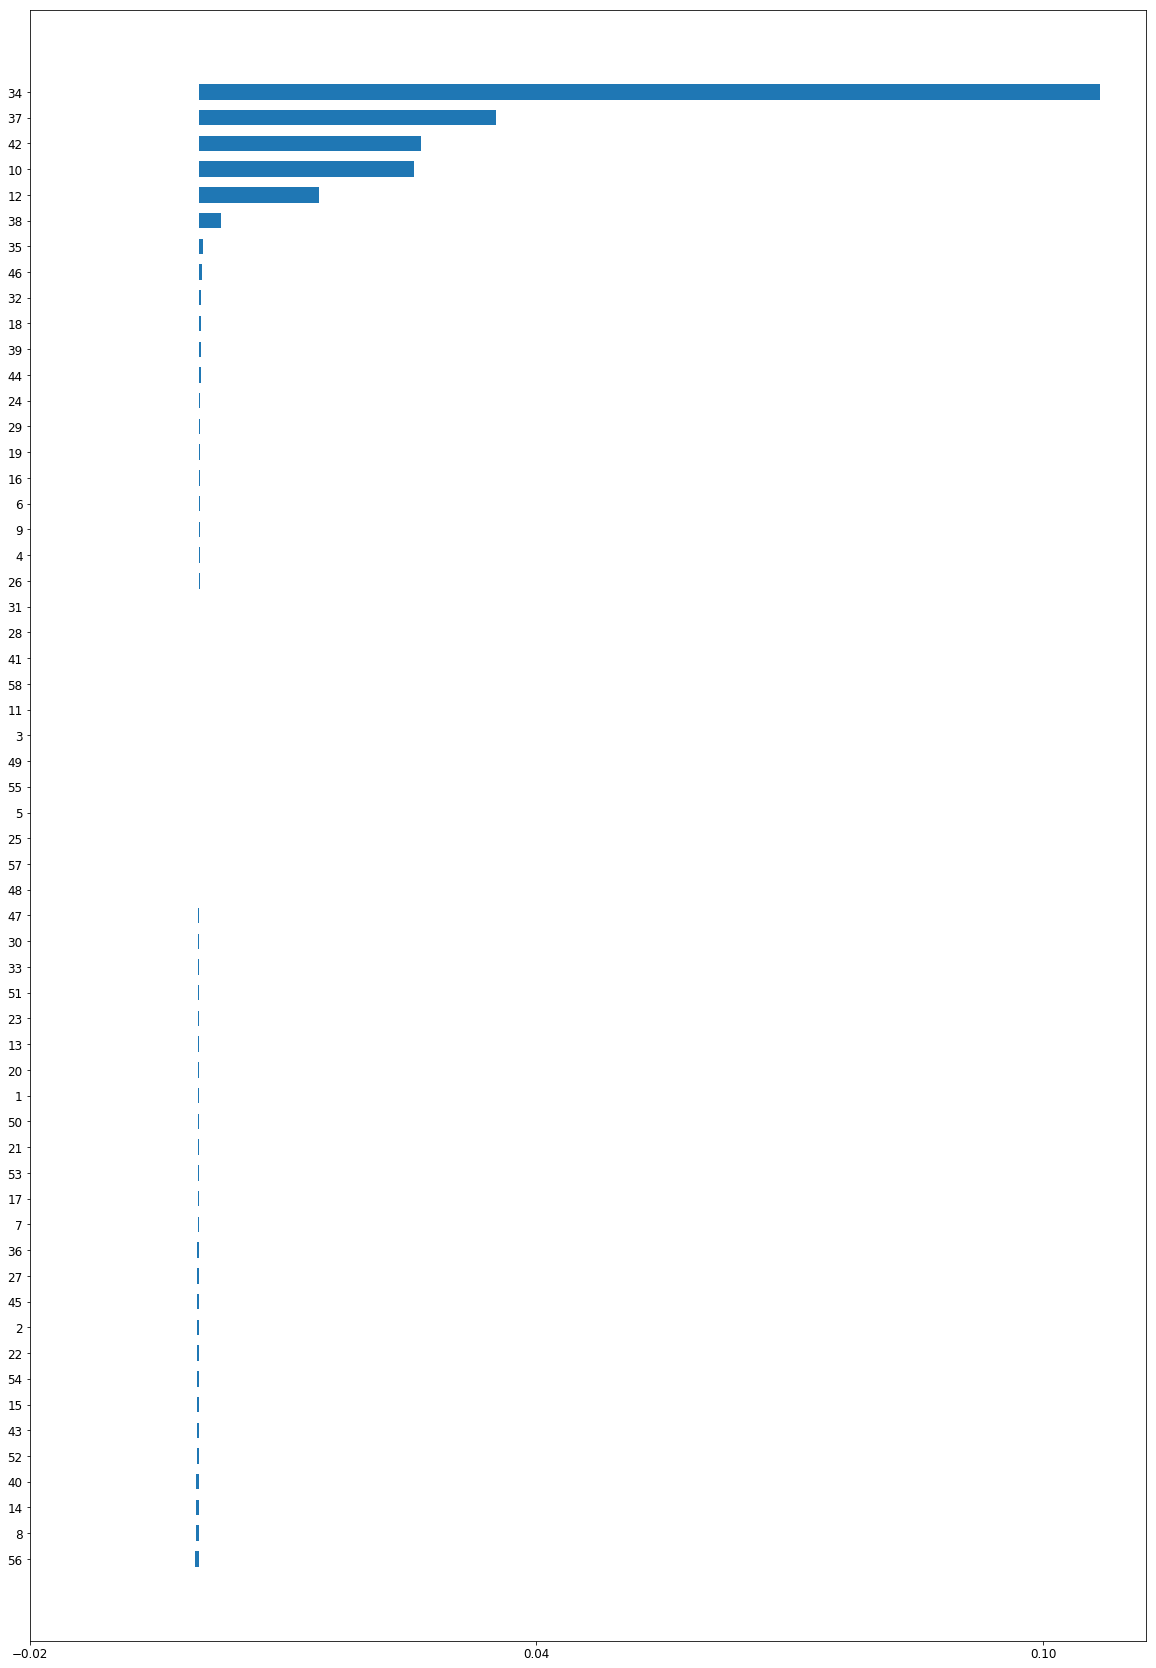

In [15]:
imp = importances(rf, X_test, y_test, n_samples=-1) # permutation
plot_importances(imp, figsize=(20, 30))

По графику выше видно, что из 58 объясняющих переменных значимое влияние на модель оказывают только первые 6

Оставим в обоих датасетах только значимые переменные

In [23]:
imp_drop = imp[6:]
imp_drop = imp_drop.index.values
imp_drop

array(['35', '46', '32', '18', '39', '44', '24', '29', '19', '16', '6',
       '9', '4', '26', '31', '28', '41', '58', '11', '3', '55', '49', '5',
       '25', '57', '48', '47', '30', '33', '51', '23', '13', '20', '1',
       '50', '21', '53', '17', '7', '36', '27', '45', '2', '22', '54',
       '15', '43', '52', '40', '14', '8', '56'], dtype=object)

In [80]:
df_raw2 = df_raw2.drop(imp_drop, axis=1)
df_raw = df_raw.drop(imp_drop, axis=1)
df_raw2.head()

,10,12,34,37,38,42,label
0,1.0,20.037239,83.114610,1.397560,13.858564,-0.031808,1
1,0.0,-44.603587,110.620332,0.846452,3.514293,6.253618,0
2,0.0,53.516062,106.354195,1.574550,105.726958,7.935197,0
3,0.0,32.640212,156.324453,2.032347,87.030045,1.650324,1
4,0.0,14.070520,35.263210,1.571146,64.538871,8.437617,0


__Перестроим RandomForest на оставшихся фичах, чтобы убедиться, что точность модели не упала__

In [27]:
df_train, df_test = train_test_split(df_raw2, test_size=0.20)

features = df_raw2.columns[~df_raw2.columns.isin(['label'])]


X_train, y_train = df_train[features], df_train['label']
X_test, y_test = df_test[features], df_test['label']

rf = RandomForestClassifier(n_estimators=40,
                            min_samples_leaf=5,
                            max_features=0.5,
                            n_jobs=-1)
%time rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)


score = roc_auc_score(y_test, y_pred[:, 1])
score

Wall time: 51.5 s


0.8022271959920056

#### Построим модель используя LightGBM

In [68]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 10000,
    'max_depth' : -1,
    'min_data_in_leaf' : 40,
    'max_bin' : 1000,
    'learning_rate': 0.2,
    'verbose': 1
}

In [69]:
features = df_raw.columns[~df_raw.columns.isin(['label'])]
lgb_train = lgb.Dataset(df_raw[features].values, label = df_raw['label'].values
              , free_raw_data=False)
%time cv = lgb.cv(params, lgb_train, num_boost_round=10)
print(max(cv['auc-mean']))
print('== // ==')
cv

Wall time: 1min 13s
0.816209581807915
== // ==


{'auc-mean': [0.7799929344952058,
  0.7934856420495536,
  0.8003737148462431,
  0.8046621229715718,
  0.8077613646219319,
  0.8101568569211735,
  0.812111139347655,
  0.8136284728118625,
  0.8150300762444044,
  0.816209581807915],
 'auc-stdv': [0.0013631336501416385,
  0.001710543048328456,
  0.001362646367521075,
  0.001014813001258977,
  0.0008833567707056398,
  0.0007862924908708863,
  0.0007906265984310554,
  0.0006415485931300125,
  0.00071543002588611,
  0.0007077272129627692]}

__Попробуем заменить значения в колонке '10' на категориальные__

In [70]:
for col in df_raw.columns:
   print(col, len(df_raw[col].value_counts()))

10 2
12 822004
34 815943
37 831796
38 816783
42 844694
label 2


In [81]:
df_raw_test = df_raw.copy()
df_raw_test['10'] = df_raw_test['10'].astype('category')
df_raw_test.head()

,10,12,34,37,38,42,label
0,1.0,20.037239,83.114610,1.397560,13.858564,-0.031808,1
1,0.0,-44.603587,110.620332,0.846452,3.514293,6.253618,0
2,0.0,53.516062,106.354195,1.574550,105.726958,7.935197,0
3,0.0,32.640212,156.324453,2.032347,87.030045,1.650324,1
4,0.0,14.070520,35.263210,1.571146,64.538871,8.437617,0


__Перестроим модель__

In [82]:
features = df_raw_test.columns[~df_raw_test.columns.isin(['label'])]
lgb_train = lgb.Dataset(df_raw_test[features].values, label = df_raw_test['label'].values
              , free_raw_data=False)
%time cv = lgb.cv(params, lgb_train, num_boost_round=10)
print(max(cv['auc-mean']))
print('== // ==')
cv

Wall time: 1min 14s
0.8159900216486207
== // ==


{'auc-mean': [0.7796098165535914,
  0.7932641902665036,
  0.7999441569020742,
  0.8043722509240337,
  0.8075046958987514,
  0.8097631857338661,
  0.8118960992647558,
  0.8136163062380646,
  0.8147566058168103,
  0.8159900216486207],
 'auc-stdv': [0.0015462146583182814,
  0.0017675984042882856,
  0.0015331937923282375,
  0.001296562618482402,
  0.0012886622428755993,
  0.0011461042410987772,
  0.0009898595848912087,
  0.0009206155381785314,
  0.0008589999967469966,
  0.0008957136513493027]}

__К сожалению добавление категориальной переменной незначительно ухудшило качество модели__

__Вернёмся к предыдущему датасету и вместо cross-validation посчитаем roc_auc на сэмпле из датасета__

In [109]:
df_train, df_test = train_test_split(df_raw, test_size=0.12)

X_train = df_train.drop('label', axis=1).values
y_train = df_train['label'].values
X_test = df_test.drop('label', axis=1).values
y_test = df_test['label'].values

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [110]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

[1]	valid_0's auc: 0.782184
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.795894
[3]	valid_0's auc: 0.802115
[4]	valid_0's auc: 0.806277
[5]	valid_0's auc: 0.80986
[6]	valid_0's auc: 0.812711
[7]	valid_0's auc: 0.814539
[8]	valid_0's auc: 0.816003
[9]	valid_0's auc: 0.817407
[10]	valid_0's auc: 0.818447
[11]	valid_0's auc: 0.819191
[12]	valid_0's auc: 0.819857
[13]	valid_0's auc: 0.820256
[14]	valid_0's auc: 0.820816
[15]	valid_0's auc: 0.819954
[16]	valid_0's auc: 0.820132
[17]	valid_0's auc: 0.820617
[18]	valid_0's auc: 0.820937
[19]	valid_0's auc: 0.82105
[20]	valid_0's auc: 0.820372
[21]	valid_0's auc: 0.820019
[22]	valid_0's auc: 0.820032
[23]	valid_0's auc: 0.819498
[24]	valid_0's auc: 0.819534
[25]	valid_0's auc: 0.819758
[26]	valid_0's auc: 0.819906
[27]	valid_0's auc: 0.819766
[28]	valid_0's auc: 0.819592
[29]	valid_0's auc: 0.819226
Early stopping, best iteration is:
[19]	valid_0's auc: 0.82105


In [111]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

score = roc_auc_score(y_test, y_pred)
score

0.8210500964243974

#### Перестроим модель на всех данных из train и сделаем предсказание на немаркированный test df

In [121]:
df_x_test = df_x_test[df_x_test.columns[df_x_test.columns.isin(df_raw.columns)]]

X_train = df_raw.drop('label', axis=1).values
y_train = df_raw['label'].values
X_test = df_x_test.values

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=19)

In [122]:
y_pred = gbm.predict(X_test)

In [126]:
submission = pd.DataFrame({
        "x": y_pred})
submission.to_csv('D:\Job/y_pred.csv', index=False)